In [59]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import matplotlib.pyplot as plt
import machinevisiontoolbox as mv
from scipy.spatial.transform import Rotation
import spatialmath
import copy

def getcube(n):
    d_x = d_y = d_z = 1 / n
    x0 = y0 = z0 = -0.5
    x = np.arange(x0, -x0, d_x, dtype=float)
    y = np.arange(y0, -y0, d_y, dtype=float)
    z = np.arange(z0, -z0, d_z, dtype=float)
    x = np.append(x, 0.5)
    y = np.append(y, 0.5)
    z = np.append(z, 0.5)
    cube = np.stack(np.meshgrid(x, y, z))
    Q = cube.reshape(3, -1)  # cube
    Q = np.swapaxes(Q, 0, 1)
    Q = Q[(abs(Q) == 0.5).sum(axis=1) >= 2]
    ones = np.ones(Q.shape[0]).reshape(Q.shape[0], 1)
    Q = np.concatenate((Q, ones), axis=1)
    Q = np.append(np.vstack(
        (x, np.zeros_like(x), np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), y, np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), np.zeros_like(x), z, np.ones_like(x))).T, Q, axis=0)
    return Q


def projectpoints(K, R, t, Q, printP=False):
    Q.reshape((Q.shape[1], Q.shape[0]))
    T = np.concatenate((R, t), axis=1)
    P = K @ T
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        p = Q[i, :]
        projected = P @ p.reshape(4, 1)
        if printP and (Q[i, :] == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
            print(P)
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx, ppsy

DEG2RAD = np.pi / 180

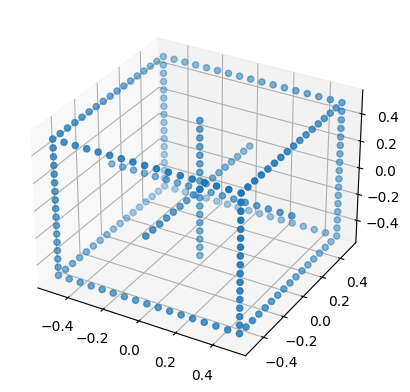

In [2]:
Q = getcube(16)
ax = plt.axes(projection='3d')
ax.scatter3D(Q[:,0],Q[:,1],Q[:,2])

In [3]:
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    "pose": spatialmath.SE3.Tz(-2.5) * spatialmath.SE3.Rx(2*DEG2RAD) * spatialmath.SE3.Ry(0*DEG2RAD) * spatialmath.SE3.Rz(3*DEG2RAD),
}
cam = mv.CentralCamera(**params)
cam, cam.K
K = cam.K
# cam rotate the camera like here : )
cam.pose = cam.pose * spatialmath.SE3.Rz(-3*DEG2RAD)
cam

           Name: default perspective camera [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 640 x 640
           pose: t = 0, 0, -2.5; rpy/yxz = 0°, 2°, 0°
   principal pt: [320.000 320.000]
   focal length: [0.008 0.008]

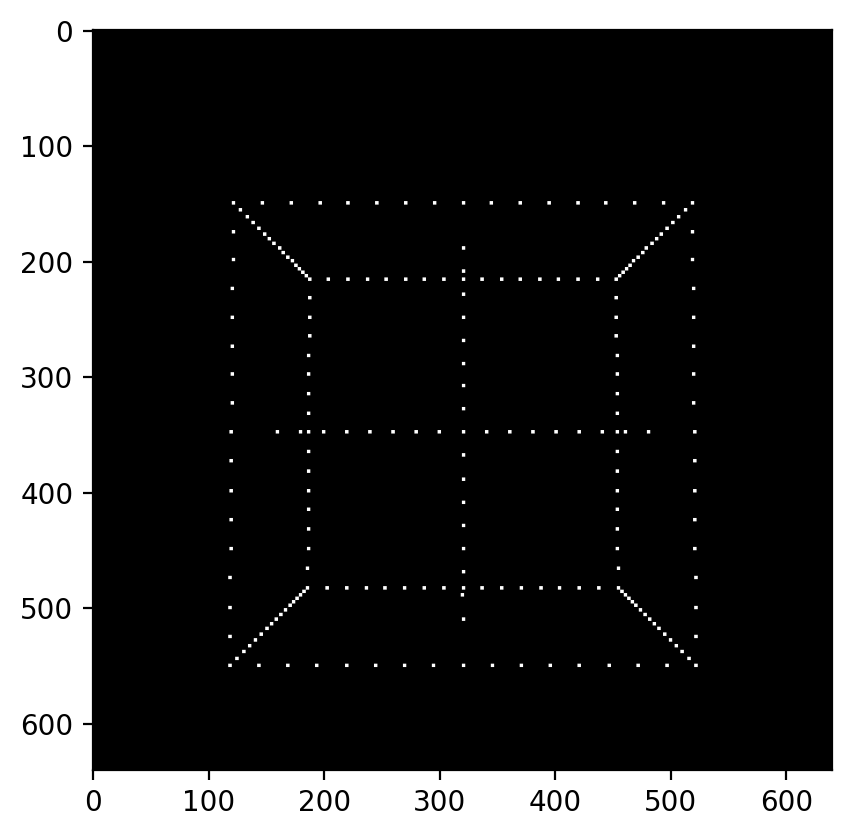

In [18]:
projected, _ = cam.project_point(Q.T[:3, :], visibility=True)
img = np.zeros((640, 640))

for i in range(projected.shape[1]):
    p = projected[:, i]
    if np.isnan(p[0]) or np.isnan(p[1]):
        continue
    u, v = int(p[1]), int(p[0])
    # img[u, v] = 255
    for j in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            if u+j < 0 or u+j >= 640 or v+k < 0 or v+k >= 640:
                continue
            img[u+j, v+k] = 255

plt.figure(dpi=200)
plt.imshow(img, cmap='gray')

In [77]:
# camera_params with shape (n_cameras, 9) contains initial estimates of parameters for all cameras. First 3 components in each row form a rotation vector (https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula), next 3 components form a translation vector.
# points_3d with shape (n_points, 3) contains initial estimates of point coordinates in the world frame.
# camera_ind with shape (n_observations,) contains indices of cameras (from 0 to n_cameras - 1) involved in each observation.
# point_ind with shape (n_observations,) contatins indices of points (from 0 to n_points - 1) involved in each observation.
# points_2d with shape (n_observations, 2) contains measured 2-D coordinates of points projected on images in each observations.

# randomly select N points
N = 20
rnd_points = np.random.choice(Q.shape[0], 20, replace=False)
points_3d = Q[rnd_points][:, :3]

cams = []
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    "pose": spatialmath.SE3.Tz(-2.5) * spatialmath.SE3.Rx(2*DEG2RAD) * spatialmath.SE3.Ry(0*DEG2RAD) * spatialmath.SE3.Rz(3*DEG2RAD),
}
cam = mv.CentralCamera(**params)
for i in range(3):
    cams.append(copy.copy(cam))
    cam.pose = cam.pose * spatialmath.SE3.Tx(-.1)

# convert to rotation vector
r = Rotation.from_matrix(cam.pose.R)
r.as_rotvec()
cam.pose.t

camera_ind = np.concatenate((np.zeros(N, dtype=np.uint8), np.ones(N, dtype=np.uint8), np.ones(N, dtype=np.uint8)*2))

point_ind = np.concatenate((np.arange(0, N, dtype=np.uint8),np.arange(0, N, dtype=np.uint8),np.arange(0, N, dtype=np.uint8)))
point_ind

points_2d = []
for i in range(3):
    projected, _ = cams[i].project_point(Q.T[:3, :], visibility=True)
    points_2d.append(np.array(projected.T)[rnd_points])

In [79]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 6].reshape((n_cameras, 6))
    points_3d = params[n_cameras * 6:].reshape((n_points, 3))
    # points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    for c in cams[camera_indices]:
        points_proj = c.project(points_3d[point_indices])
    return (points_proj - points_2d).ravel()